In [53]:
#-----------------------Laboratorio 08----------------------------
#Luiz Felipe Barros Alves
#Mat: 120110674

In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

C:\Users\alves\AppData\Local\Temp\ipykernel_14020\3778166921.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
modeApi = lumapi.MODE(hide = False)

In [4]:
# units
um = 1e-6
nm = 1e-9

In [119]:
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'

gap = 200*nm

x_span_core =  5*um
y_span_core =  450*nm
z_span_core =  220*nm

x_core = 0*um
y_core = y_span_core+gap
z_core = 0.0*um

wg90Raius = 10*um

## Create  Acoplador direcional


In [120]:
modeApi.switchtolayout()
modeApi.deleteall()

modeApi.addrect()
modeApi.set("name", "Lc")
modeApi.set("material", core_material)
modeApi.set("x", x_core)
modeApi.set("x span", x_span_core)
modeApi.set("y", y_core)
modeApi.set("y span", y_span_core)
modeApi.set("z", z_core)
modeApi.set("z span", z_span_core)

modeApi.copy()
modeApi.set("name", "Lc_lower")
modeApi.set("y", 0)
modeApi.set('x span', x_span_core*5)

modeApi.addobject("90_bend_wg")
modeApi.set("name", "right")
modeApi.set("base height", z_span_core)
modeApi.set("base width", y_span_core)
modeApi.set("first axis", 'z')
modeApi.set('radius', wg90Raius)
modeApi.set('rotation 1', -90)
modeApi.set('x', x_span_core/2)
modeApi.set('y', y_core+wg90Raius)
modeApi.set('z', z_core)
modeApi.set('material', core_material)

modeApi.copy()
modeApi.set("name", "left")
modeApi.set('rotation 1', 180)
modeApi.set('x', -x_span_core/2)

## Create Solver

In [121]:
# Definir material
fde_solve_material = sub_material

# Definir dimensões e outras características
x_fde = 0*nm
z_span_fde = wg90Raius/10
y_fde = 0*um
y_span_fde = wg90Raius/4
z_fde = 0.0 * um

mesh_cells = 100
mesh_multiplier = 8
number_modes = 4

wavelength = 1550*nm

In [122]:
# Adicionar solver
modeApi.switchtolayout()
modeApi.select('FDE')
modeApi.delete()
modeApi.select('mesh')
modeApi.delete()

modeApi.addfde()
modeApi.set("solver type", "2D X normal")
modeApi.set("background material", fde_solve_material)
modeApi.set("x", x_fde)
modeApi.set("y span", y_span_fde)
modeApi.set("y", 500*nm)
modeApi.set("z span", z_span_fde )
modeApi.set("z", z_fde)
modeApi.set("z min bc", "PML")
modeApi.set("z max bc", "PML")
modeApi.set("y min bc", "PML")
modeApi.set("y max bc", "PML")
modeApi.set("mesh cells z", mesh_cells)
modeApi.set("mesh cells y", mesh_cells)
modeApi.set('number of trial modes', number_modes)
modeApi.set('wavelength', wavelength)

# Add mesh
modeApi.addmesh()
modeApi.set('set mesh multiplier', True)
modeApi.set('x', x_fde)
modeApi.set('x span', 0)
modeApi.set('x mesh multiplier', mesh_multiplier)
modeApi.set('y', 500*nm)
modeApi.set('y span', y_span_fde)
modeApi.set('y mesh multiplier', mesh_multiplier)
modeApi.set('z span', z_span_fde)
modeApi.set('z', z_fde)

## Índice efetivo 

In [123]:
nmbOFModes = int(modeApi.findmodes())
n1 = modeApi.getresult('FDE::data::mode1', 'neff')
n2 = modeApi.getresult('FDE::data::mode2', 'neff')

print(f'Índice mode1: {n1}\nÍndice mode2: {n2}')

Índice mode1: [[2.37162082+0.00020704j]]
Índice mode2: [[2.33959424+0.00013825j]]


## Perfil de campo

In [174]:
eField = np.squeeze(modeApi.getresult("FDE::data::mode1", "Ey"))
z_efield = modeApi.getresult('FDE::data::mode1', 'z')/um
y_efield = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_x'))

v = np.linspace(-1, 1, 2000, endpoint=True)


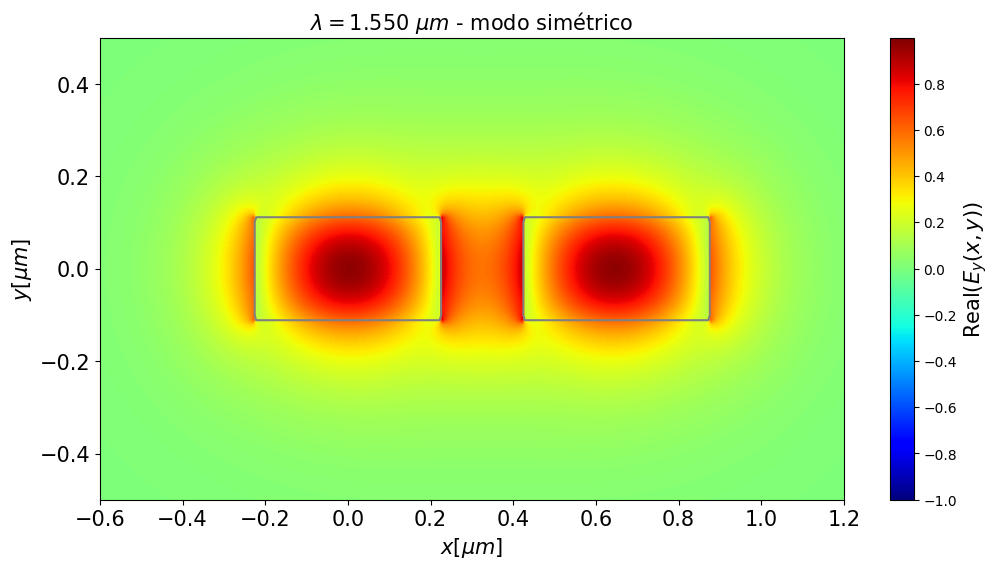

In [175]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
Y, Z = np.meshgrid(y_efield, z_efield)

plt.contour(Y, Z, np.rot90(rfIndex.real), 0, colors='gray', origin='upper')
#plt.contour(X, Y, np.rot90(eField.real), v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(Y, Z, np.rot90(eField.real), v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
# colorbar.set_ticks(v)
colorbar.set_label(r'Real($E_{y}(x,y))$', fontsize=15)

plt.xlabel(r'$x [\mu m]$', fontsize=15)
plt.ylabel(r'$y [\mu m]$', fontsize=15)
plt.title(r'$\lambda = %.3f \ \mu m$ - modo simétrico'%(1e6*wavelength), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.axis('equal')
plt.xlim([-0.6, 1.2])
plt.ylim([-0.5, 0.5])

plt.savefig('Perfil_mode_1_2D_x_Normal.png', bbox_inches='tight')
plt.show()

In [133]:
eField = np.squeeze(modeApi.getresult("FDE::data::mode2", "Ey"))
z_efield = modeApi.getresult('FDE::data::mode1', 'z')/um
y_efield = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_x'))

v = np.linspace(-1, 1, 2000, endpoint=True)

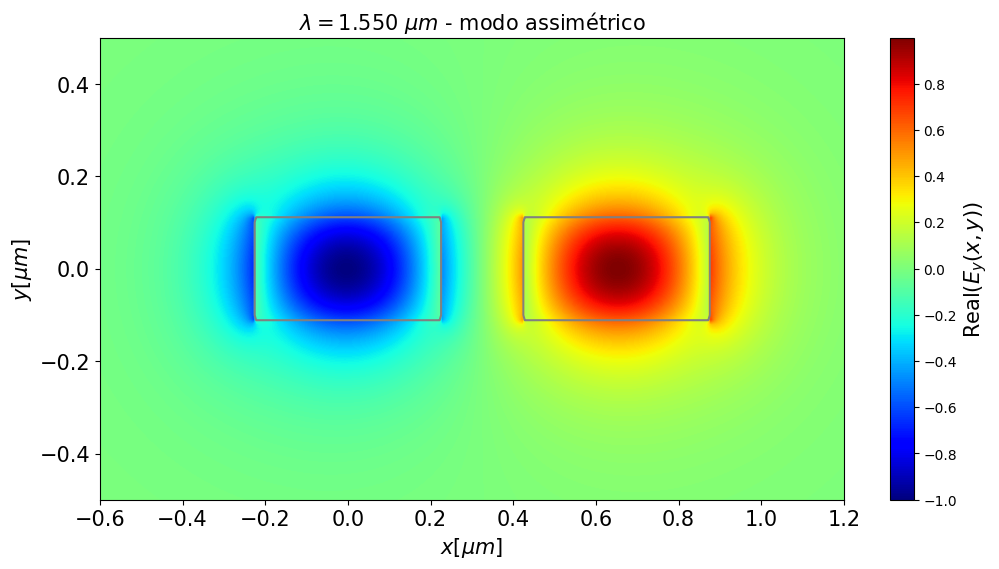

In [173]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
Y, Z = np.meshgrid(y_efield, z_efield)

plt.contour(Y, Z, np.rot90(rfIndex.real), 0, colors='gray', origin='upper')
#plt.contour(X, Y, np.rot90(eField.real), v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(Y, Z, np.rot90(eField.real), v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
# colorbar.set_ticks(v)
colorbar.set_label(r'Real($E_{y}(x,y))$', fontsize=15)

plt.xlabel(r'$x [\mu m]$', fontsize=15)
plt.ylabel(r'$y [\mu m]$', fontsize=15)
plt.title(r'$\lambda = %.3f \ \mu m$ - modo assimétrico'%(1e6*wavelength), fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.axis('equal')
plt.xlim([-0.6, 1.2])
plt.ylim([-0.5, 0.5])

plt.savefig('Perfil_mode_2_2D_x_Normal.png', bbox_inches='tight')
plt.show()

## Análise de convergência

In [58]:
modeApi.switchtolayout()
modeApi.select('mesh')
modeApi.delete()

mesh_vector = np.linspace(5, 200, 20)
neff_vector_M1 = np.array([])
neff_vector_M2 = np.array([])

for i in mesh_vector:
    modeApi.switchtolayout()
    modeApi.select('FDE')
    modeApi.set("mesh cells z", i)
    modeApi.set("mesh cells y", i)
    
    modeApi.findmodes()
    n_M1 = modeApi.getresult('FDE::data::mode1', 'neff')
    neff_vector_M1 = np.append(neff_vector_M1, n_M1.real)
    n_M2 = modeApi.getresult('FDE::data::mode2', 'neff')
    neff_vector_M2 = np.append(neff_vector_M2, n_M2.real)

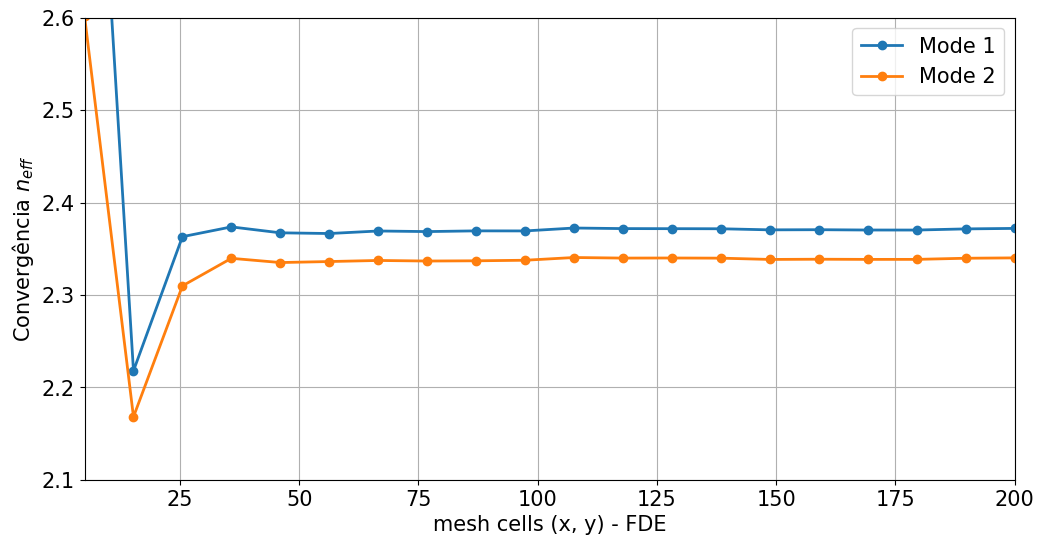

In [116]:
plt.figure(figsize=(12,6))
plt.plot(mesh_vector, neff_vector_M1, 'o-', linewidth=2, label='Mode 1')
plt.plot(mesh_vector, neff_vector_M2, 'o-', linewidth=2, label='Mode 2')
plt.xlabel('mesh cells (x, y) - FDE', fontsize=15)
plt.ylabel('Convergência $n_{eff}$', fontsize=15)
plt.xlim(5, 200)
plt.ylim(2.1, 2.6)
plt.grid()
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('Convergencia.png', bbox_inches='tight')
plt.show()

## Análise - comprimento de acoplamento em função da distância entre guias 

In [66]:
modeApi.switchtolayout()

modeApi.select('FDE')
modeApi.set("mesh cells z", mesh_cells)
modeApi.set("mesh cells y", mesh_cells)

modeApi.select('mesh')
modeApi.delete()

# Add mesh
modeApi.addmesh()
modeApi.set('set mesh multiplier', True)
modeApi.set('x', x_fde)
modeApi.set('x span', 0)
modeApi.set('x mesh multiplier', mesh_multiplier)
modeApi.set('y', 500*nm)
modeApi.set('y span', y_span_fde)
modeApi.set('y mesh multiplier', mesh_multiplier)
modeApi.set('z span', z_span_fde)
modeApi.set('z', z_fde)

gap_vector = np.linspace(0*nm, 500*nm, 20)


delta_n = np.array([])
for i in gap_vector:
    modeApi.switchtolayout()

    modeApi.select('Lc')
    modeApi.set("y", y_span_core + i)

    modeApi.select('right')
    modeApi.set("y", y_span_core + i + wg90Raius)

    modeApi.select('left')
    modeApi.set("y", y_span_core + i + wg90Raius)

    modeApi.findmodes()
    n1 = modeApi.getresult('FDE::data::mode1', 'neff')
    n2 = modeApi.getresult('FDE::data::mode2', 'neff')

    delta_n = np.append(delta_n, np.abs(n1.real - n2.real))

Lx = wavelength / (2 * delta_n)

In [167]:
from scipy.optimize import curve_fit

def exp_model(gap, a, b):
    return a * np.exp(b * gap)

# Exemplo de dados (gap_vector e Lx são seus dados experimentais)
# gap_vector -> distância entre guias, Lx -> comprimento de acoplamento

# Realizando o ajuste de curva
params, covariance = curve_fit(exp_model , gap_vector, Lx/um)

# Extraindo os parâmetros ajustados
a_fit, b_fit = params

# Criando uma curva ajustada para plotar
fit_curve = exp_model(gap_vector, a_fit, b_fit)

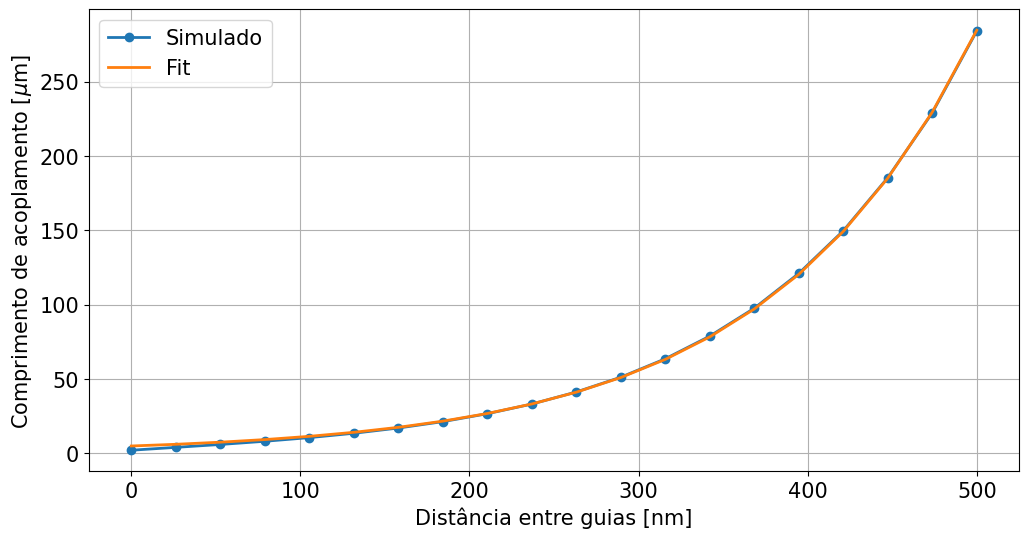

In [176]:
fig = plt.figure(figsize=(12, 6))
plt.plot(gap_vector / nm, Lx / um, 'o-', linewidth=2, label='Simulado')
plt.plot(gap_vector / nm, fit_curve, '-', linewidth=2, label='Fit')
plt.xlabel('Distância entre guias [nm]', fontsize=15)
plt.ylabel('Comprimento de acoplamento [$\mu$m]', fontsize=15)
# plt.xlim([gap[0] / nm, gap[-1] / nm])
plt.grid()
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('Lx_versus_gap_linear_FIT.png', bbox_inches='tight')
plt.show()


## Análise - acoplamento de potência em função do comprimento do dispositivo

In [68]:
modeApi.switchtolayout()

modeApi.select('Lc')
modeApi.set("y", y_core)

modeApi.select('right')
modeApi.set("y", y_core+wg90Raius)

modeApi.select('left')
modeApi.set("y", y_core + wg90Raius)

modeApi.findmodes()
n1 = modeApi.getresult('FDE::data::mode1', 'neff')
n2 = modeApi.getresult('FDE::data::mode2', 'neff')


delta_n = np.abs(n1.real-n2.real)

L_x = wavelength / (2 * delta_n)

lenDC = np.linspace(0, 500 * um, 10000)
tSqr = np.squeeze((np.cos(np.pi / 2 * lenDC / L_x))**2)
kappaSqr = np.squeeze((np.sin(np.pi / 2 * lenDC / L_x))**2)



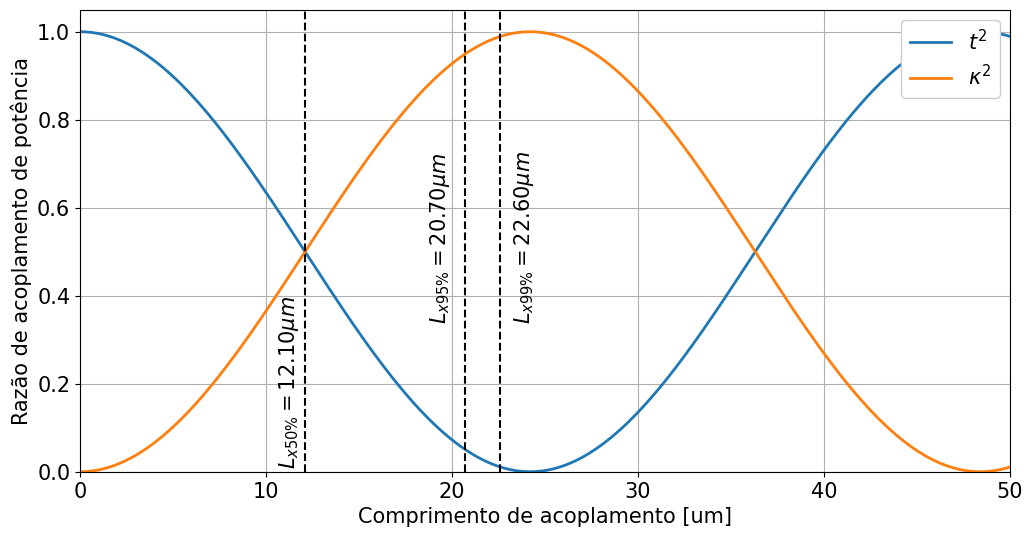

242
12.101210121012102
414
20.702070207020704
452
22.602260226022604


In [118]:
fig = plt.figure(figsize=(12, 6))
plt.plot(lenDC / um, tSqr, linewidth=2, label='$t^2$')
plt.plot(lenDC / um, kappaSqr, linewidth=2, label='$\kappa^2$')
plt.plot([12.10, 12.10], [0, 1.05], '--k')
plt.plot([20.70, 20.70], [0, 1.05], '--k')
plt.plot([22.60, 22.60], [0, 1.05], '--k')


plt.xlabel('Comprimento de acoplamento [um]', fontsize=15)
plt.ylabel('Razão de acoplamento de potência', fontsize=15)
plt.xlim([0, 50])
plt.ylim([0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc=1, fontsize=15, framealpha=1)

# LEGENDA VERTICAL
plt.text(12.10-1.5, 0.02,r'$L_{x50\%}=12.10\mu m$', rotation = 90, fontsize=15)
plt.text(20.70-2, 0.35,r'$L_{x95\%}=20.70\mu m$', rotation = 90, fontsize=15)
plt.text(22.60+0.6, 0.35,r'$L_{x99\%}=22.60 \mu m$', rotation = 90, fontsize=15)

plt.savefig('acoplamento_pot.png', bbox_inches='tight')
plt.show()


tol = 0.001

for i in range(len(kappaSqr)):
    if ((kappaSqr[i] <= 0.5 + tol) and (kappaSqr[i] >= 0.5 - tol)):
        print(i)
        print(lenDC[i]/um)
        break

for i in range(len(kappaSqr)):
    if ((kappaSqr[i] <= 0.95 + tol) and (kappaSqr[i] >= 0.95 - tol)):
        print(i)
        print(lenDC[i]/um)
        break

for i in range(len(kappaSqr)):
    if ((kappaSqr[i] <= 0.99 + tol) and (kappaSqr[i] >= 0.99 - tol)):
        print(i)
        print(lenDC[i]/um)
        break


## Encerrar simulação

In [64]:
# modeApi.close()